# Example: simulating observations of Gaia stars with G-band magnitude < 10.0

In [1]:
import sys
sys.path.append('../')
from STLib.sensor import Sensor
from STLib.filter import Filter
from STLib.lens import Lens
from STLib.camera import Camera
from STLib.sources import AstronomicalSources, SpectralSources, MagnitudeSources, SolarSystemSources
from STLib.functions.psf import airyPSFModel, defocusPSFModel, pillboxPSFModel, gaussianPSFModel
from STLib.functions.dark import exponentialDarkModel
from STLib.utils import spectraConeSearch, sbdbQuery

import STLib
# `from ... import ...` will create a copy, which we don't want for this global setting.
STLib.utils.debug.ENABLE_TIMER = True

from datetime import datetime, UTC, timedelta
from astropy import units
from astropy.time import Time
import numpy as np
np.random.seed(1)  # reproducibility

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib widget

In [2]:
# from STLib import downloadBasicData
# downloadBasicData()

## Construct Camera Model

### Lens

Define the aperture, focal length, and point spread function (PSF).

There are several built-in PSF models:

- Airy disk (diffraction limited PSF): 
  - The intensity is given by: $I(x,y) = I_0\left[\dfrac{2J_1[\nu]}{\nu}\right]^2$, where $\nu = \dfrac{\pi D \cdot \sqrt{x^2+y^2}}{\lambda \cdot \sqrt{x^2+y^2+f^2}}$.
  - We care about flux (or power), which is $\displaystyle \int\int I(x,y) \;dxdy \cdot \dfrac{\pi \cdot (D/2)^2}{(\lambda f)^2}$.
  - $I_0$ is the maximum intensity, $J_1$ is the 1st order Bessel function of the first kind.
  - $x, y$ are the sample coordinates on the detector plane with the optical axis as $(0, 0)$, 
  - $f$ is the focal length, $D$ is the aperture diameter, and $\lambda$ is the wavelength of the source.
- Defocused PSF:
  - Defined in Eq. 40 of [Basic Wavefront Aberration Theory for Optical Metrology](https://wp.optics.arizona.edu/jcwyant/wp-content/uploads/sites/13/2016/08/03-BasicAberrations_and_Optical_Testing.pdf) by Wyant and Creath.
  - Additional credit goes to [this blog](https://www.strollswithmydog.com/a-simple-model-for-sharpness-in-digital-cameras-defocus/).
  - The power is given by: $\dfrac{P_\text{tot}\pi}{\lambda\cdot(f/D)}\cdot \displaystyle \left\lvert\int_0^1 e^{i \frac{2\pi}{\lambda} W_{020} \rho^2} \cdot J_0\bigg[\dfrac{\pi r}{\lambda\cdot(f/D)} \rho \bigg] \cdot \rho \;d\rho\right\rvert^2$.
  - $P$ is the total power, $J_0$ is the 0th order Bessel function of the first kind;
  - $W_{020}$ is the peak optical path difference (the term that controls defocus).
- Gaussian PSF:
  - The power is given by a 2D Gaussian distribution with mean $\mathbf{0}$ and covariance $\mathbf{\Sigma}$.
- Pillbox PSF:
  - The power is given by $P(x,y) = \begin{cases} P_\text{tot} / (\pi R^2) & \text{, } x^2+y^2 < R^2 \\ 0 & \text{, otherwise} \end{cases}$
  - This generates a flat PSF within a circle of radius $R$.

Custom PSF equations can be defined with the following format:
```python
    def customPSF(x: Number, y: Number) -> float:
```
where the input args will be (x, y) coordinates in `astropy.units.micron`. Verify that the integral of the output approaches unity. Note that the custom PSF will be dynamically type-checked, so type hints are necessary (`Number = typing.Union[int, float]`).

In [3]:
aperture = 50 * units.mm
focal_length = 30 * units.mm
wavelength = 550 * units.nm  # only needed by defocusPSFModel

# the `psf` returned by <name>PSFModel is a function.
# psf = airyPSFModel(wavelength=wavelength, aperture=aperture, focal_length=aperture)
# psf = defocusPSFModel(wavelength=wavelength, aperture=aperture, focal_length=focal_length, defocus=1.0*wavelength)
# psf = pillboxPSFModel(radius=6*units.micron)
psf = gaussianPSFModel(sigma=10*units.micron)

The lens is defined by the aperture, focal length, transmission efficiency, PSF, and lens distortion. 

The Brown-Conrady lens distortion model (see [here](https://docs.nvidia.com/vpi/algo_ldc.html) and <a href="https://en.wikipedia.org/wiki/Distortion_(optics)#Software_correction)">here</a>) is defined by radial terms `k1`-`k6` and tangential terms `p1`, `p2`.

For computational reasons, the PSF model will only be computed within the nearest rectangular grid of pixels relative to the center of the ray. The PSF is numerically integrated over each pixel; by default the bounds of integration and step size are tuned automatically. Alternatively, you can flag `auto_tune_integration_params = False`, then provide your own integration bounds via `psf_bounds` in astropy length units and the number of grid points for integration via `psf_resolution`. 

In [4]:
lens = Lens(aperture=aperture, focal_length=focal_length, 
            transmission_efficiency=0.99, 
            k1=0.4, k2=0.1, k4=0.1,
            p1=0.01,
            psf=psf, auto_tune_integration_params=True)

In the simulation, the PSF is integrated numerically over each pixel by sampling a uniformly spaced grid. The argument `psf_bounds` determines the ±x, ±y range -- in microns -- where the PSF has meaningful value and should be computed. The argument `psf_resolution` specifies the number of grid points along each axis. The tuning function used under the hood is shown below; the tuning tolerances can be adjusted. 

In [5]:
_bounds, _grid_size = lens.tuneIntegrationParams(atol=1e-5,rtol=1e-5,btol=1e-1,gtol=1e-1)
print(f"Tuning results: `psf_bounds` = {_bounds:.3f}, `psf_resolution` = {_grid_size}")

Tuning results: `psf_bounds` = 14.453 micron, `psf_resolution` = 1.2031250000000002 micron


In [6]:
lens.psf_bounds = _bounds
lens.psf_resolution = _grid_size

### Filter

The Gaia G band zero point flux can be found from the [Spanish Virtual Observatory](https://svo2.cab.inta-csic.es/theory/fps/index.php?id=GAIA/GAIA3.G&&mode=browse&gname=GAIA&gname2=GAIA3#filter).

In [7]:
Vega_zero_point_Gaia_bp_band = 4.07852e-9 * units.erg / units.cm**2 / units.s / units.angstrom
filt = Filter(file='../data/filters/gaia/GAIA.GAIA3.Gbp.xml', zp_flux=Vega_zero_point_Gaia_bp_band)

### Sensor

Define the dark current model. Currently, the only built-in dark current model is an exponential model. 

You can add your own model which should adhere to the following format:
```python
    customDark(T: Number) -> float:
```
The function should return `astropy.units.pA / astropy.units.cm**2`.

In [8]:
darkFunc = exponentialDarkModel(I0 = 0.5, T0 = 20, dT = 10)

Define the sensor with the following parameters:
- `width_px`/`height_px`: number of pixels in width/height.
- `px_len`: size of pixel in microns. If scalar, the pixel is assumed to be square. Rectangular pixels can be defined with a tuple specifying `(width, height)`.
- `px_pitch`: spacing between pixels in microns. Can be scalar or tuple similar to `px_len`.
- `quantum_efficiency`: average filter QE in range $[0,1]$.
- `dark_current`: dark current function as discussed above.
- `hot_pixels`: 2D array of scalars which scale the output of `dark_current`. Use `hot_pixels=None` for no hot pixels, which is equivalent to `hot_pixels=np.ones((height_px,width_px))`.
- `gain`: electron to ADU conversion factor.
- `bias`: scalar, 1D array, or 2D array. Represents a voltage bias in the readout process to prevent negative readings. If scalar, assumes uniform bias. If 1D array, assumes bias is column-dependent. If 2D array, assumes bias is given per pixel. Assumes units of `astropy.units.adu`.
- `full_well_capacity`: charge capacity in units of `astropy.units.electron`.
- `adc_limit`: limit of the ADC counter, typically an even power of 2.
- `bloom`: subset of `{'+x','-x','+y','-y'}`, indicates which direction(s) electrons can leak into if a pixel is saturated. 
- `readout_time`: (planned feature) time needed to read out an image row by row.
- `read_noise`: mean read noise in units of `astropy.units.electron`.

In [9]:
NUM_ROWS = 600
NUM_COLS = 400

BIAS = np.ones(NUM_COLS) * 20
bad_bias_rate = 0.005
bad_cols = np.random.choice(np.arange(NUM_COLS, dtype=int), int(np.ceil(bad_bias_rate * NUM_COLS)), replace=False)
BIAS[bad_cols] = 500

HOT_PX = np.ones((NUM_ROWS, NUM_COLS))
hot_rate = 0.001
bad_px = np.random.choice(np.arange(NUM_COLS*NUM_ROWS, dtype=int), int(np.ceil(hot_rate * NUM_COLS*NUM_ROWS)), replace=False)
HOT_PX.ravel()[bad_px] = np.random.rand(len(bad_px)) * 10 + 5

sensor = Sensor(width_px=NUM_COLS, height_px=NUM_ROWS, 
                px_len=6, px_pitch=6.5, 
                quantum_efficiency=0.3, dark_current=darkFunc, hot_pixels=HOT_PX,
                gain=5, bias=BIAS, full_well_capacity=2e4, adc_limit=2**16,
                bloom=set(), 
                readout_time=0, read_noise=25)

### Source Stars

We will first take a dark image, so define a source with no stars. Later in this notebook we will look at adding sources.

In [10]:
sources_dark = AstronomicalSources(ra=None, dec=None, source_id=None)

### Camera

The camera is defined by hardware including `lens`, `filter`, and `sensor`;

Its environment: `sources` and `sky_mag`;

Its orientation: `ra`, `dec`, and `roll`; and

Its states, defined by a SPICE kernel `kernel` and current time `time`. 

In [11]:
orex_kernel = "../data/kernels/orx_240210_290101_240410_od389-R-DSM3-P-DSM5_v1.bsp"
initial_time = Time("2028-04-05", format='iso', scale='utc')

camera = Camera(lens=lens, filter_=filt, sensor=sensor, sources=sources_dark, sky_mag=21.5, kernel=orex_kernel, time=initial_time)

## Lens Distortion Visualization

We can visualize the lens distortion as follows:

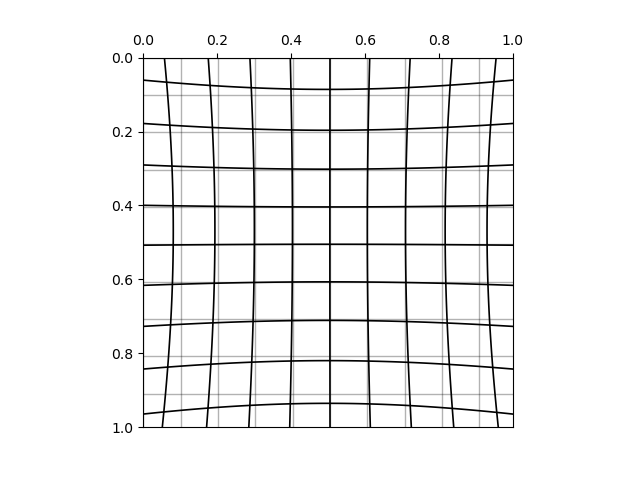

In [12]:
num_rows = 100
num_cols = 100
col_step = 10
row_step = 10
_x = np.linspace(0,1,num_cols)
_y = np.linspace(0,1,num_rows)
X,Y = np.meshgrid(_x,_y)
Xd, Yd = camera._lens.applyDistortion(X,Y)

fig, ax = plt.subplots()

# reference grid
for col in range(0, num_cols, col_step):
    ax.plot(X[:,col], Y[:,col], c='k', alpha=0.3, lw=1)
for row in range(0, num_rows, row_step):
    ax.plot(X[row,:], Y[row,:], c='k', alpha=0.3, lw=1)

# distorted grid
for col in range(0, num_cols, col_step):
    ax.plot(Xd[:,col], Yd[:,col], c='k', lw=1.2)
for row in range(0, num_rows, row_step):
    ax.plot(Xd[row,:], Yd[row,:], c='k', lw=1.2)
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.invert_yaxis()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()

## Dark Image

Take an image with no stars to simulate a dark image.

In [13]:
camera._sensor.clear()
image = camera.snap(exposure_time=1, temperature=10, close_shutter=True)

Function '_applyBloom' took 0.000 seconds.


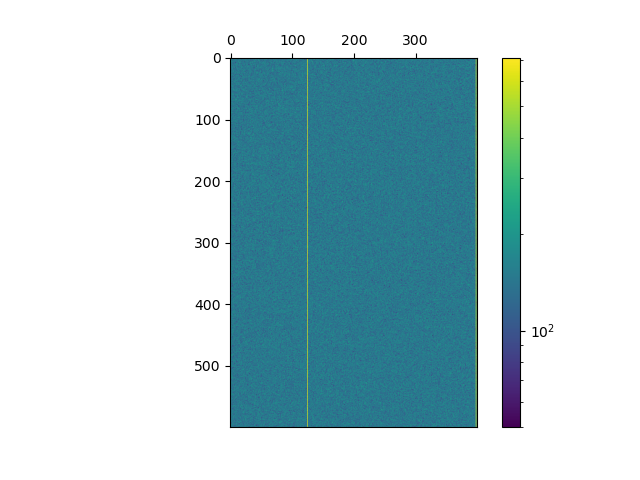

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(image, norm=LogNorm())
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.colorbar(im)
plt.show()

## Gaia Image + Asteroids

### Gaia Stars

We can now choose a camera pointing and image some real stars. In this example, we will use a utility function to query the Gaia database for stars based on magnitude and FOV constraints. It is also possible to simply supply _all_ stars regardless of FOV; they will be culled during the calculations. Although this doesn't really affect the simulation time, supplying an all-sky database of stellar spectra requires a lot of storage (roughly 200 MB for coarse spectra of stars down to 8th magnitude in Gaia's G-band after doing some tricks to reduce the size).

In [15]:
RA   = 214.62 * units.degree
DEC  = -7.52 * units.degree
ROLL = 45 * units.degree
MAG_CUTOFF = 10.0

In [16]:
max_radius = 1.05 * np.sqrt(camera.fov[0]**2 + camera.fov[1]**2)
spectral_stars, magnitude_stars = spectraConeSearch(ra=RA, dec=DEC, radius=max_radius, mag_cutoff=MAG_CUTOFF, cache=True)

Using cached results from /Users/tiger/.starsim/cache/gaia/2ee4033d008a37cb5bf30b45b094c3542999d128.xml .
Missing spectra for 468/1696 (27.6%) of stars; their magnitudes will be supplied instead.


Construct the sources. Note that for magnitude-only sources, the magnitude and zero point must be consistent with the selected filter. 

In [17]:
spectral_sources = SpectralSources(
    ra = spectral_stars['ra'],
    dec = spectral_stars['dec'],
    source_id = spectral_stars['source_id'],
    spectral_flux_density=spectral_stars['spectral_flux_densities'],
    sfd_wavelength=spectral_stars['wavelengths']
    )

magnitude_sources_g = MagnitudeSources(
    ra = magnitude_stars['ra'],
    dec = magnitude_stars['dec'],
    source_id = magnitude_stars['source_id'],
    magnitude = magnitude_stars['magnitudes_g']
    )

### Asteroids

We also want to see if any small bodies (e.g., asteroids) within the Solar System will be visible. To do this, we first need to query the Small Body Database (SBDB) for a list of small bodies meeting certain criteria, then obtain their ephemeris files via JPL Horizons. 

In [18]:
# the default results from `STLib.downloadBasicData()`` is stored in `STLib.DEFAULT_SMALL_BODIES_PATH`.
# sbdb_query_results = sbdbQuery(orbit_class=STLib.DEFAULT_SMALL_BODIES_GROUPS, Hmax=8)
sbdb_query_results = STLib.DEFAULT_SMALL_BODIES_PATH

In [19]:
# use SBDB query results to perform JPL Horizons queries
# override any existing files by setting the max cache age to 0 (days)
start_date = datetime(2024,1,1,tzinfo=UTC)
end_date   = datetime(2030,1,1,tzinfo=UTC)
asteroids = SolarSystemSources(start_date=start_date, end_date=end_date, small_bodies_query_results=sbdb_query_results)

### Generate image

In [20]:
camera._sensor.clear()
camera.time = initial_time
camera.sources = [spectral_sources, magnitude_sources_g, asteroids]
camera.orientation = [RA, DEC, ROLL]
image = camera.snap(exposure_time=0.2, temperature=20, close_shutter=False) / camera.sensor.adc_limit.value

Function '_applyPSF' took 0.047 seconds.
Function '_applyBloom' took 0.000 seconds.


The specific ra, dec we looked at is actually centered on Ceres. If we take multiple exposures over time, you can see the motion of Ceres across the image (from the center towards the bottom right).

In [21]:
STLib.utils.debug.ENABLE_TIMER = False  # don't need to see the timing information every time
for ii in range(10):
    camera.time += timedelta(days=0.05)
    image = camera.snap(exposure_time=0.2, temperature=20, close_shutter=False) / camera.sensor.adc_limit.value

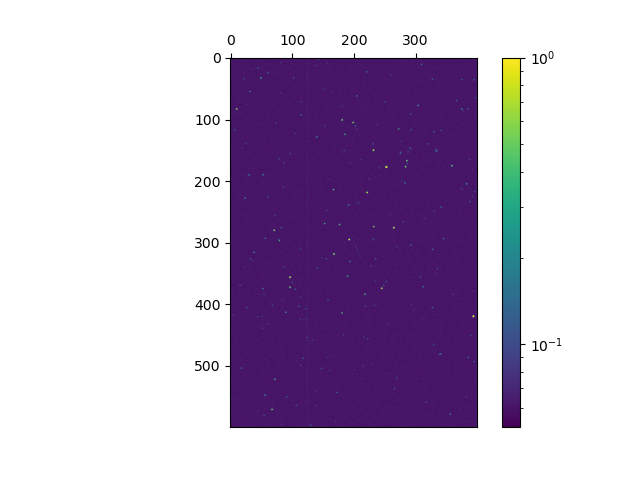

In [22]:
fig, ax = plt.subplots()
im = ax.imshow(image, norm=LogNorm())
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.colorbar(im)
plt.show()

### Export image

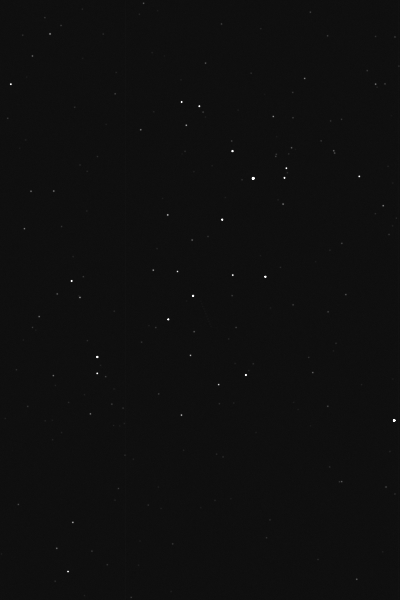

In [23]:
from PIL import Image
image_uint8 = (image * 255.999).astype(np.uint8)
im = Image.fromarray(image_uint8, mode='L')
display(im)

Try uploading the results to a star identification algorithm (e.g. [astrometry.net](https://nova.astrometry.net/))!

In [24]:
im.save('example-images/gaia-test.png')

## Combining Filters to Create A Color Image

Gaia has a G filter + two photometers (blue and red). We will create filters corresponding to each of them.

The zero points of these filters can be found from the [Spanish Virtual Observatory](https://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=GAIA&gname2=GAIA3&asttype=).

In [25]:
Vega_zero_point_Gaia_bp = 4.07852e-9 * units.erg / units.cm**2 / units.s / units.angstrom
Vega_zero_point_Gaia_G  = 2.50386e-9 * units.erg / units.cm**2 / units.s / units.angstrom
Vega_zero_point_Gaia_rp = 1.26902e-9 * units.erg / units.cm**2 / units.s / units.angstrom

filt_r = Filter(file='../data/filters/gaia/GAIA.GAIA3.Grp.xml', zp_flux=Vega_zero_point_Gaia_rp)
filt_g = Filter(file='../data/filters/gaia/GAIA.GAIA3.G.xml'  , zp_flux=Vega_zero_point_Gaia_G)
filt_b = Filter(file='../data/filters/gaia/GAIA.GAIA3.Gbp.xml', zp_flux=Vega_zero_point_Gaia_bp)

Since the stars' magnitudes will be different depending on the filter, we will also need to construct new light sources for stars that don't have spectra.

In [26]:
magnitude_sources_bp = MagnitudeSources(
    ra = magnitude_stars['ra'],
    dec = magnitude_stars['dec'],
    source_id = magnitude_stars['source_id'],
    magnitude = magnitude_stars['magnitudes_bp']
    )

magnitude_sources_rp = MagnitudeSources(
    ra = magnitude_stars['ra'],
    dec = magnitude_stars['dec'],
    source_id = magnitude_stars['source_id'],
    magnitude = magnitude_stars['magnitudes_rp']
    )

Some convenience functions for touching up the image.

In [27]:
def adjustContrast(image, vmin=0, vmax=1):
    return image * (vmax-vmin) + vmin
def adjustGamma(image, gamma):
    return image**gamma
def adjustBrightness(image, brightness):
    return np.minimum(1.0, image*brightness)

In [28]:
camera.time = initial_time

camera._sensor.clear()
camera.filter_ = filt_r
camera.sources = [spectral_sources, magnitude_sources_rp, asteroids]
image_r = camera.snap(exposure_time=1, temperature=20) / camera.sensor.adc_limit.value

camera._sensor.clear()
camera.filter_ = filt_g
camera.sources = [spectral_sources, magnitude_sources_g, asteroids]
image_g = camera.snap(exposure_time=1, temperature=20) / camera.sensor.adc_limit.value

camera._sensor.clear()
camera.filter_ = filt_b
camera.sources = [spectral_sources, magnitude_sources_bp, asteroids]
image_b = camera.snap(exposure_time=1, temperature=20) / camera.sensor.adc_limit.value

In [29]:
GAMMA = 1.0
BRIGHTNESS = 1

# Gaia's blue photometer basically covers the entire range of human eye spectral sensitivity,
# so realistically what you'd see would be closer to the single channel image from above.
# Nonetheless, we can generate a pretty false color image.

# Since the G filter has about twice the bandpass of the other two filters,
# we'll make an artistic choice to scale down its contribution to the green channel. 
image_r_adj = adjustBrightness(adjustGamma(image_r, GAMMA), BRIGHTNESS)
image_g_adj = adjustBrightness(adjustGamma(image_g*0.8, GAMMA), BRIGHTNESS)
image_b_adj = adjustBrightness(adjustGamma(image_b, GAMMA), BRIGHTNESS)

rgb = np.dstack((image_r_adj, image_g_adj, image_b_adj))
rgb_uint8 = np.round(rgb * 255).astype(np.uint8)

im = Image.fromarray(rgb_uint8)

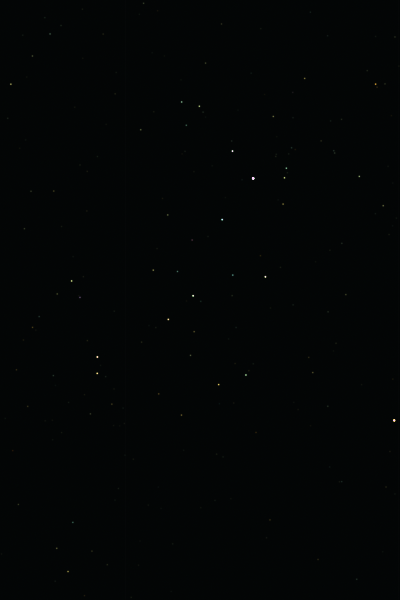

In [30]:
display(im)

In [31]:
im.save('example-images/gaia-test-color.png')